In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [float(e) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till)
        m = sum(elems) / len(elems)
        yield m

In [2]:
def make_read_write_graph(ax, basedir, title, scalability=False, n_threads=1, rng=None, latency=False, show_caches=True, show_cpu=True, show_gpu=True, skip=1):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm')]
    numerical.sort()
    if rng is not None:
        numerical = numerical[rng[0]:rng[1]]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=skip))
    results2 = list(results_generator(l, basedir + '/hbm', skip=skip))
    #results3 = list(results_generator(l, basedir + '/mmio', skip=0, till=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    if latency:
        ax.set_ylabel('Latency (ns)')
    else:
        ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR')
    ax.plot(numerical, results2, 'x', label='HBM')
    #ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability and show_caches:
        if show_cpu:
            if n_threads > 1:
                ax.axvline(x=65536*n_threads, linestyle=(0, (1, 10)), label = f'CPU L1 x {n_threads}')
                ax.axvline(x=1048576*n_threads, linestyle=(0, (3, 10, 1, 10)), label = f'CPU L2 x {n_threads}')
            ax.axvline(x=65536, ls=':', label = f'CPU L1')
            ax.axvline(x=1048576, ls='-.', label = f'CPU L2')
            ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        if show_gpu:
            ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
            ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

def make_copy_graph(ax, basedir, title, scalability=False, show_caches=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_ddr')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr_ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm_hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/hbm_ddr', skip=1))
    results4 = list(results_generator(l, basedir + '/ddr_hbm', skip=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR->DDR')
    ax.plot(numerical, results2, 'x', label='HBM->HBM')
    ax.plot(numerical, results3, 's', label='HBM->DDR')
    ax.plot(numerical, results4, '^', label='DDR->HBM')
    if not scalability and show_caches:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

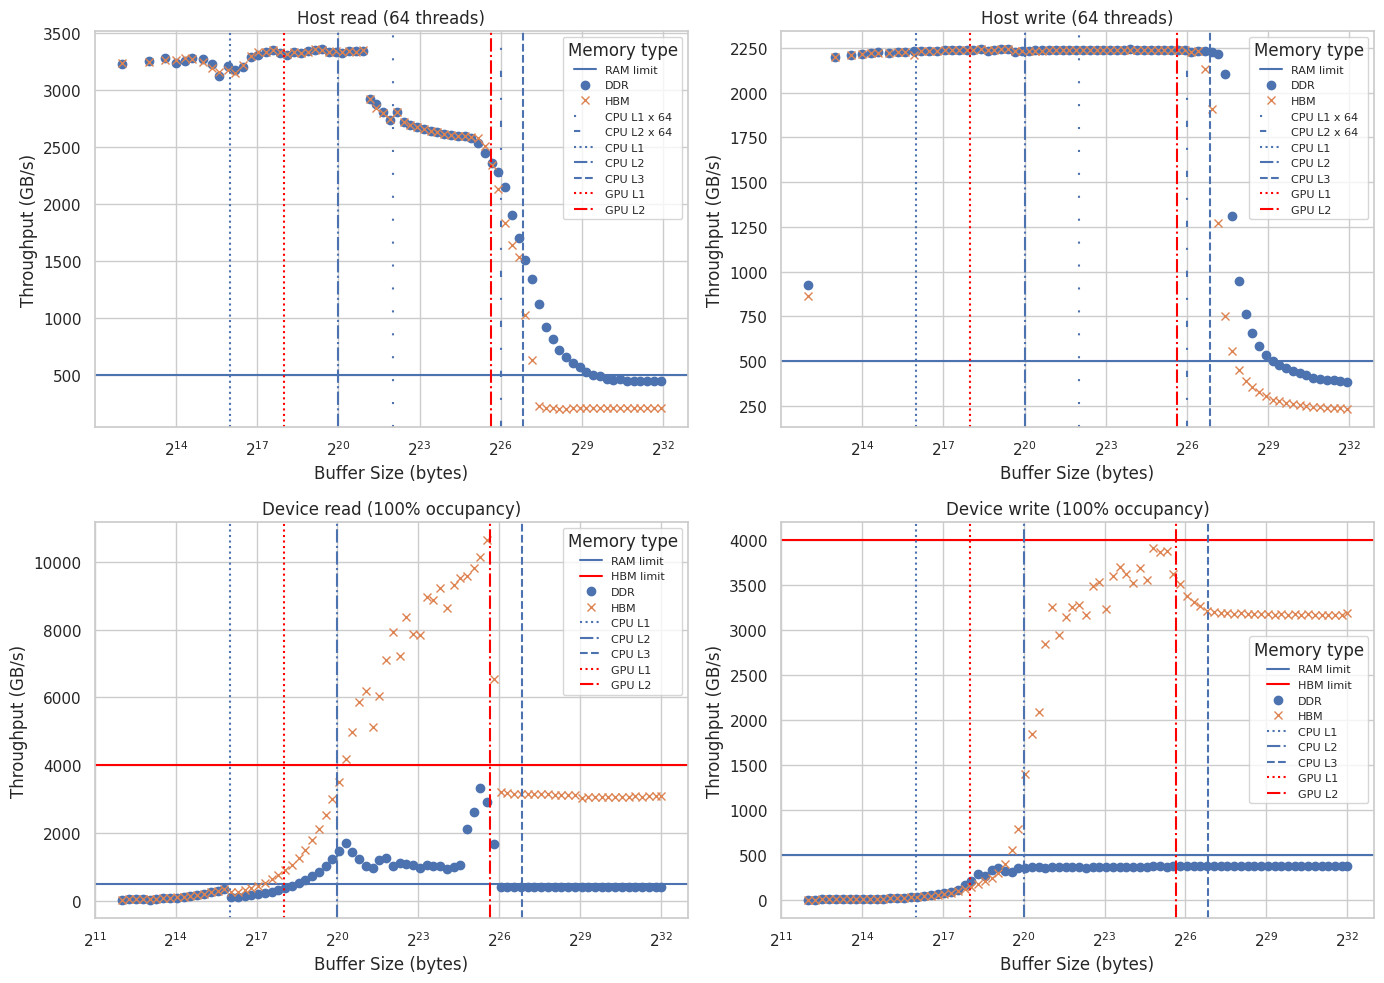

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
ax1.axhline(y=500, label='RAM limit')
make_read_write_graph(ax1, 'results/read/host', 'Host read (64 threads)', False, 64)
ax2.axhline(y=500, label='RAM limit')
make_read_write_graph(ax2, 'results/write/host', 'Host write (64 threads)', False, 64)
ax3.axhline(y=500, label='RAM limit')
ax3.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax3, 'results/read/device', 'Device read (100% occupancy)')
ax4.axhline(y=500, label='RAM limit')
ax4.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax4, 'results/write/device', 'Device write (100% occupancy)')
plt.tight_layout()

host ddr read max 19.169533333333334
host hbm read max 7.580887777777777
device ddr read max 0.04583301111111111
device hbm read max 0.12861777777777778
device ddr write max 1.6350999999999998
device hbm write max 1.6350999999999998


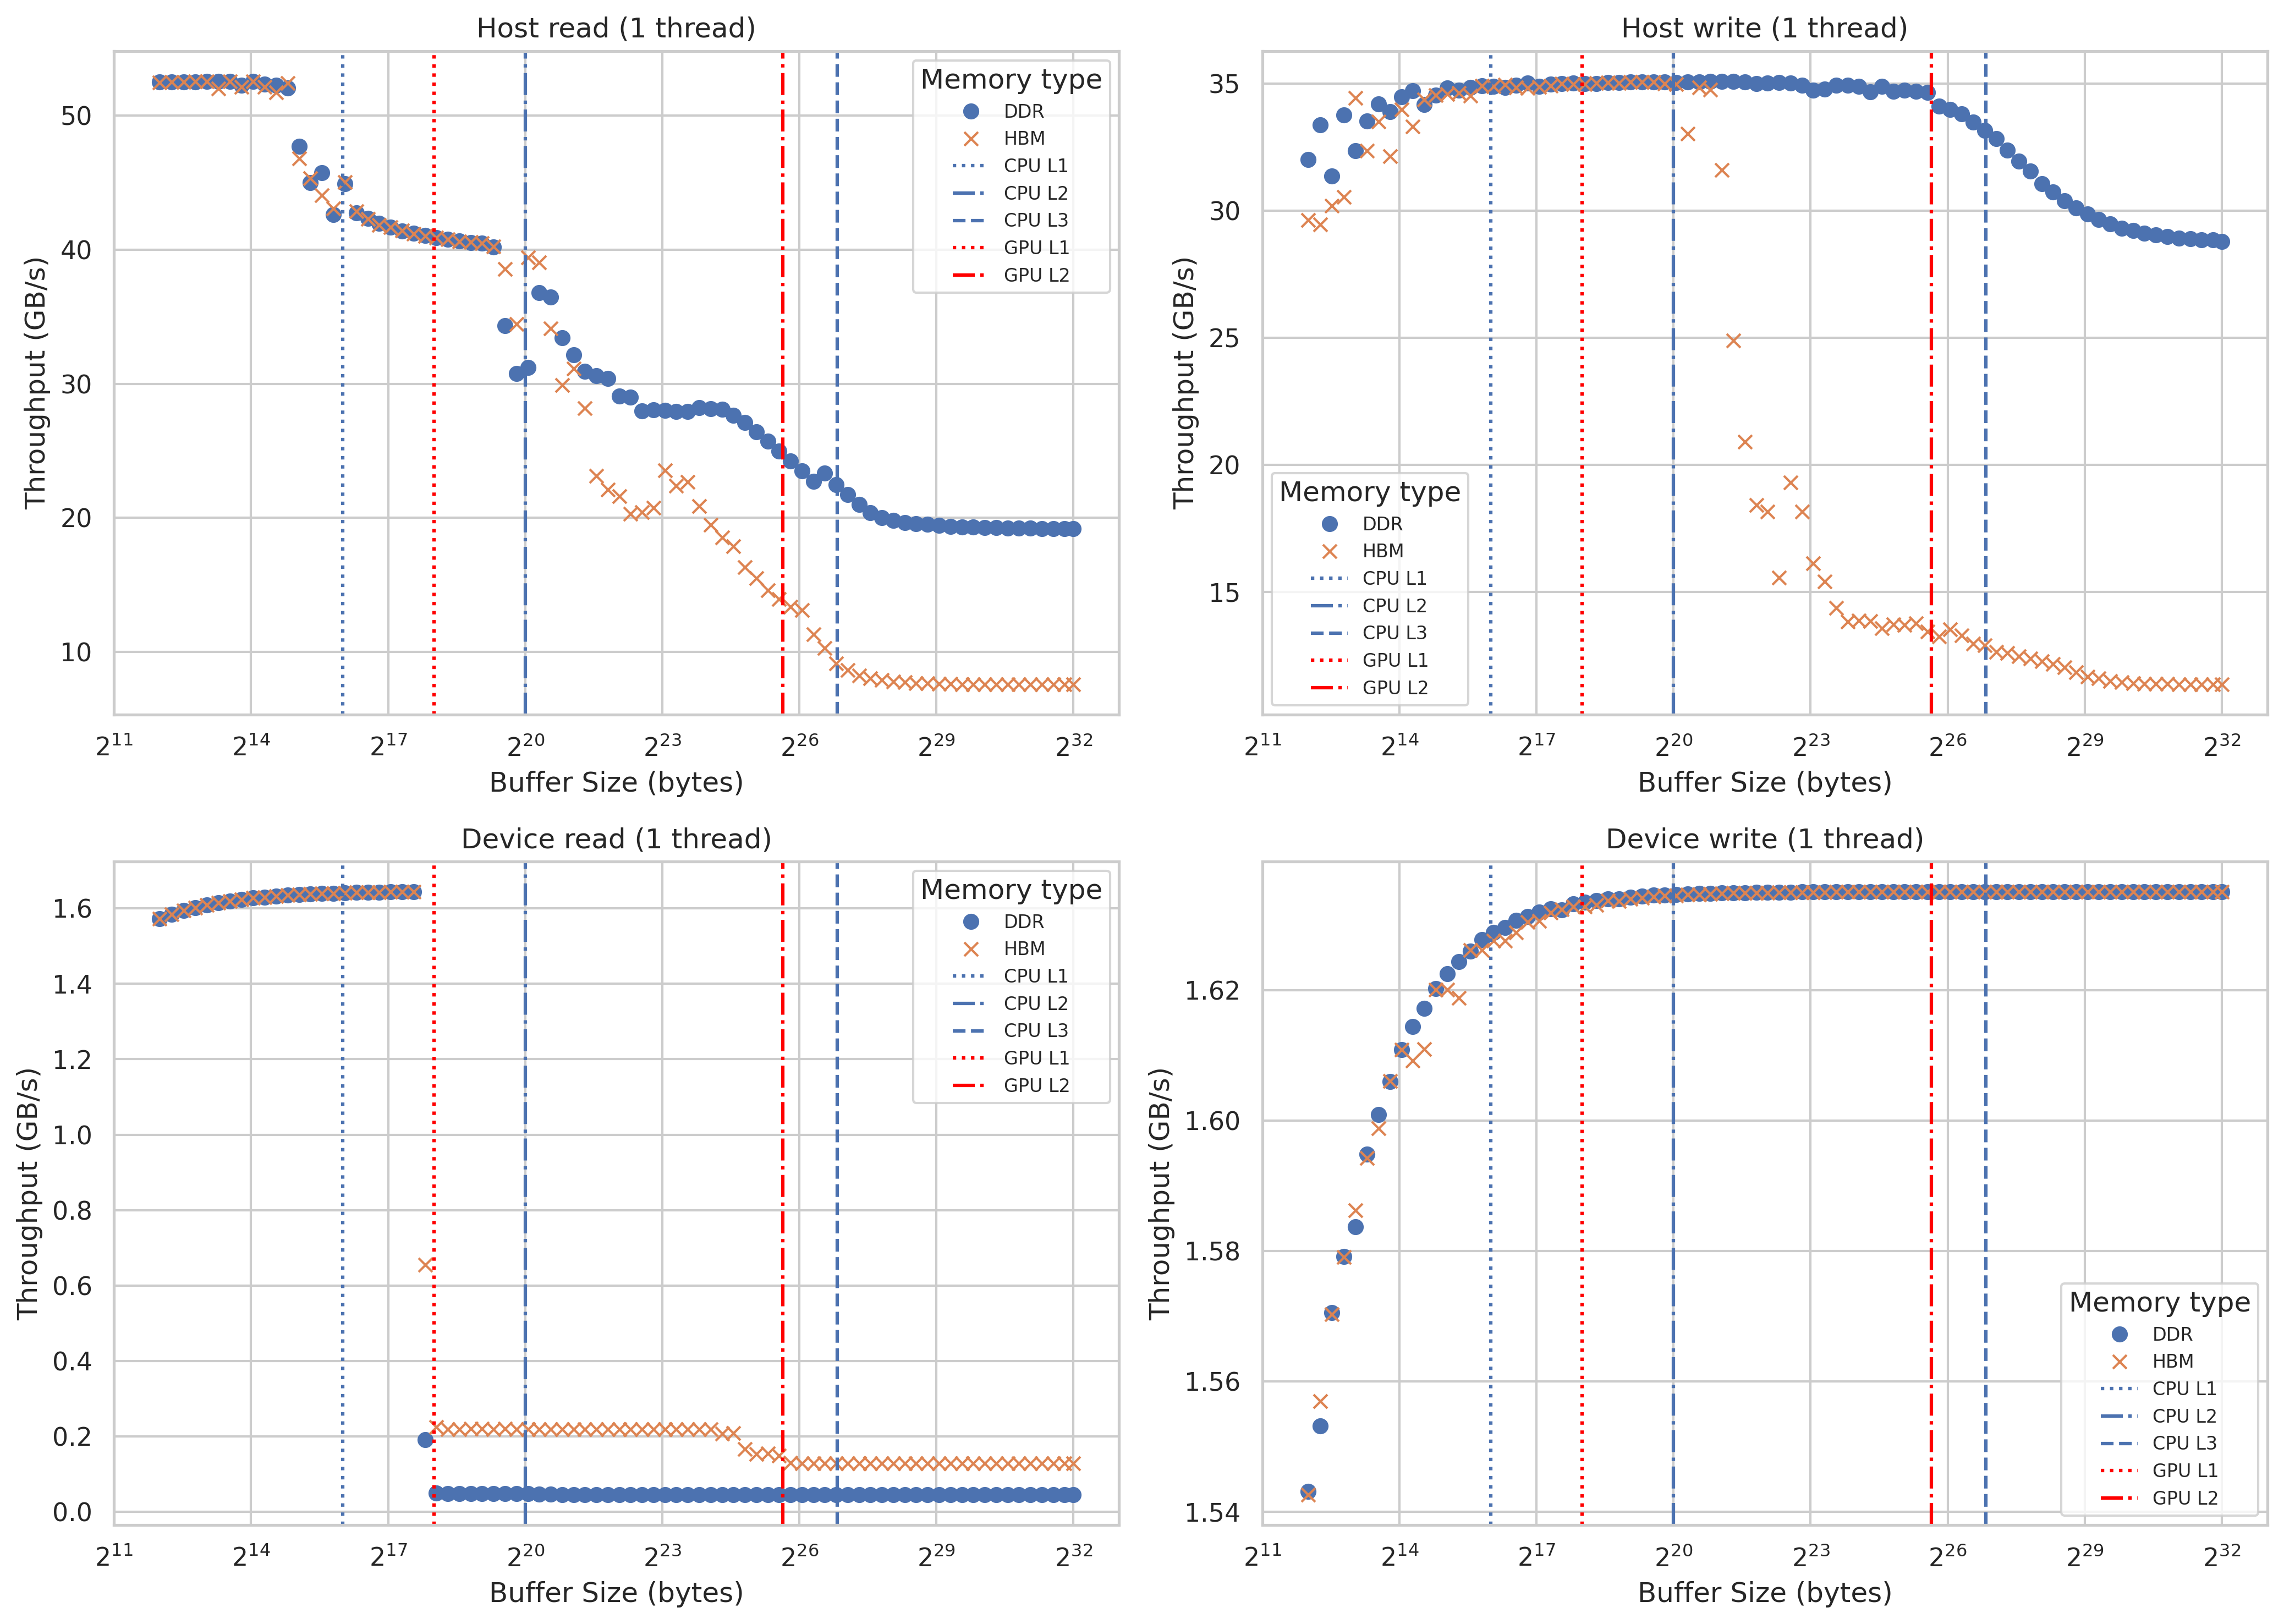

In [98]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
make_read_write_graph(ax1, 'results/read/host/single', 'Host read (1 thread)')
make_read_write_graph(ax2, 'results/write/host/single', 'Host write (1 thread)')
make_read_write_graph(ax3, 'results/read/device/single', 'Device read (1 thread)')
make_read_write_graph(ax4, 'results/write/device/single', 'Device write (1 thread)')
fig.set_dpi(300)
plt.tight_layout()

#getting maxes
host_reads = list(results_generator([str(2**32)], 'results/read/host/single/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr read max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/read/host/single/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm read max {host_reads[0]}')

device_reads = list(results_generator([str(395303808)], 'results/read/device/single/ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr read max {device_reads[0]}')
device_reads = list(results_generator([str(395303808)], 'results/read/device/single/hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm read max {device_reads[0]}')
device_writes = list(results_generator([str(2**32)], 'results/write/device/single/ddr', skip=1))
device_writes_argmax = np.argmax(device_writes)
print(f'device ddr write max {device_writes[0]}')
device_writes = list(results_generator([str(2**32)], 'results/write/device/single/hbm', skip=1))
device_writes_argmax = np.argmax(device_writes)
print(f'device hbm write max {device_writes[0]}')

device ddr_ddr copy max 204.35244444444447
device hbm_hbm copy max 1439.8366666666666
device hbm_ddr copy max 370.2203333333333
device ddr_hbm copy max 408.51188888888896
device ddr_ddr copy max 0.03924515555555556
device hbm_hbm copy max 0.08753192222222222


FileNotFoundError: [Errno 2] No such file or directory: 'results/copy/device/single/hbm_ddr/4294967296'

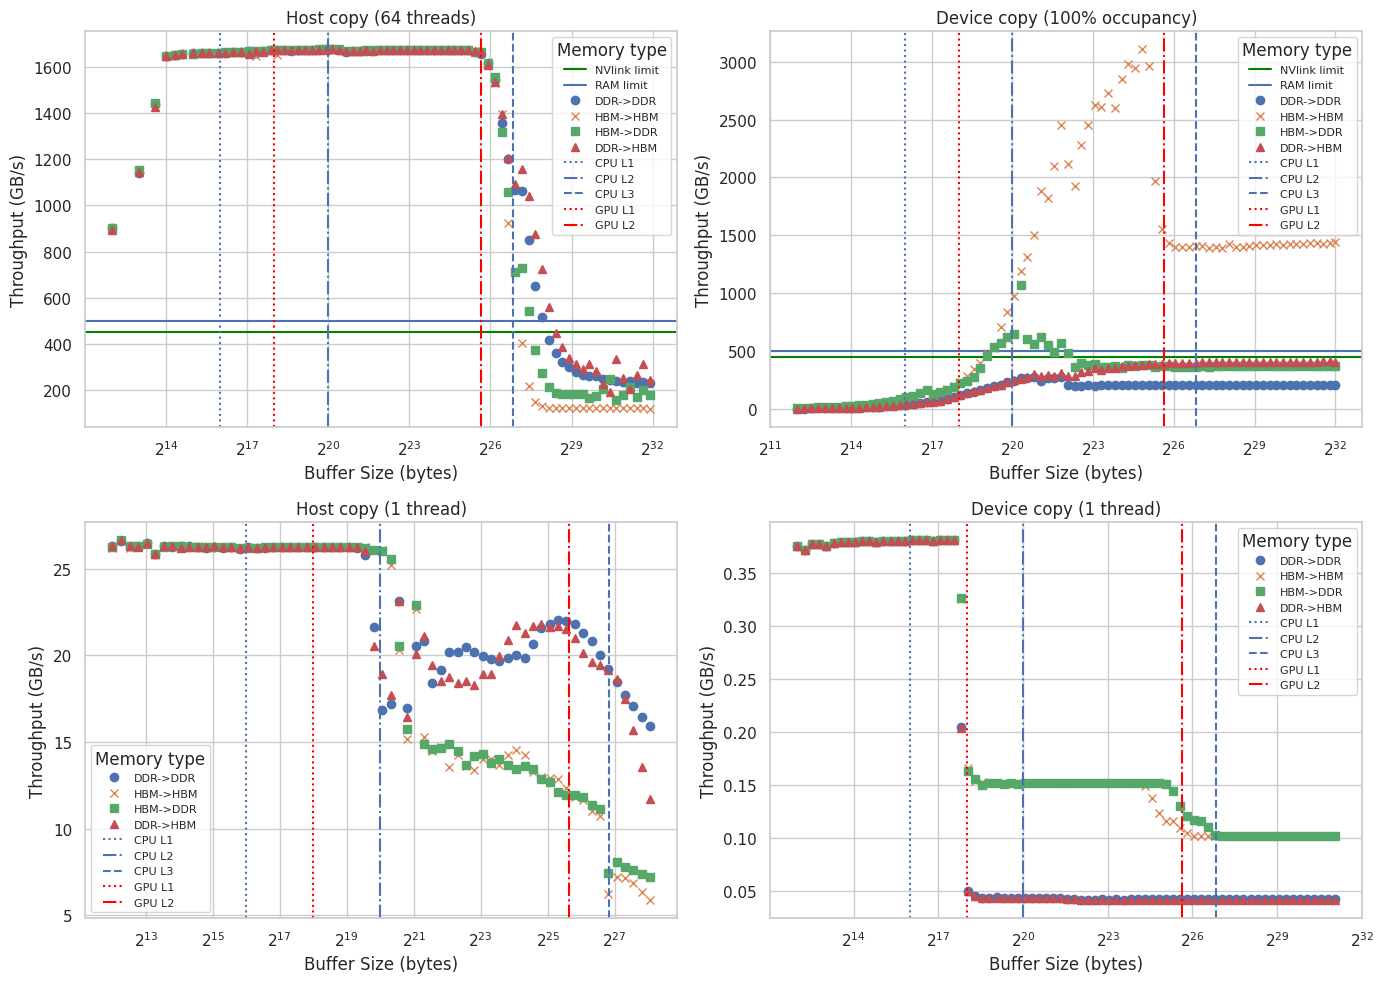

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
make_copy_graph(ax1, 'results/copy/host', 'Host copy (64 threads)')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
# ax2.axhline(y=4000, color='red', label='HBM limit')
make_copy_graph(ax2, 'results/copy/device', 'Device copy (100% occupancy)')
make_copy_graph(ax3, 'results/copy/host/single', 'Host copy (1 thread)')
make_copy_graph(ax4, 'results/copy/device/single', 'Device copy (1 thread)')
plt.tight_layout()

#getting maxes
device_reads = list(results_generator([str(2**32)], 'results/copy/device/ddr_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/hbm_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_hbm copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/hbm_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/ddr_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_hbm copy max {device_reads[0]}')

device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/ddr_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/hbm_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_hbm copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/hbm_ddr', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device hbm_ddr copy max {device_reads[0]}')
device_reads = list(results_generator([str(2**32)], 'results/copy/device/single/ddr_hbm', skip=1))
device_reads_argmax = np.argmax(device_reads)
print(f'device ddr_hbm copy max {device_reads[0]}')

host ddr memset max 361.64777777777783
host hbm memset max 215.63433333333336
host ddr memset max 29.912933333333335
host hbm memset max 11.514366666666664
host ddr write max 362.5586666666667 (62 threads)
host hbm write max 230.36055555555555 (37 threads)
host ddr_ddr memcpy max 12.934788888888889
host hbm_hbm memcpy max 4.745177777777778
host hbm_ddr memcpy max 6.6445944444444445
host ddr_hbm memcpy max 7.872682222222222
host ddr->ddr copy max 218.03733333333332 (39 threads)
host hbm->hbm copy max 110.39688888888888 (61 threads)
host hbm->ddr copy max 172.2037777777778 (37 threads)
host ddr->hbm copy max 217.49222222222224 (46 threads)


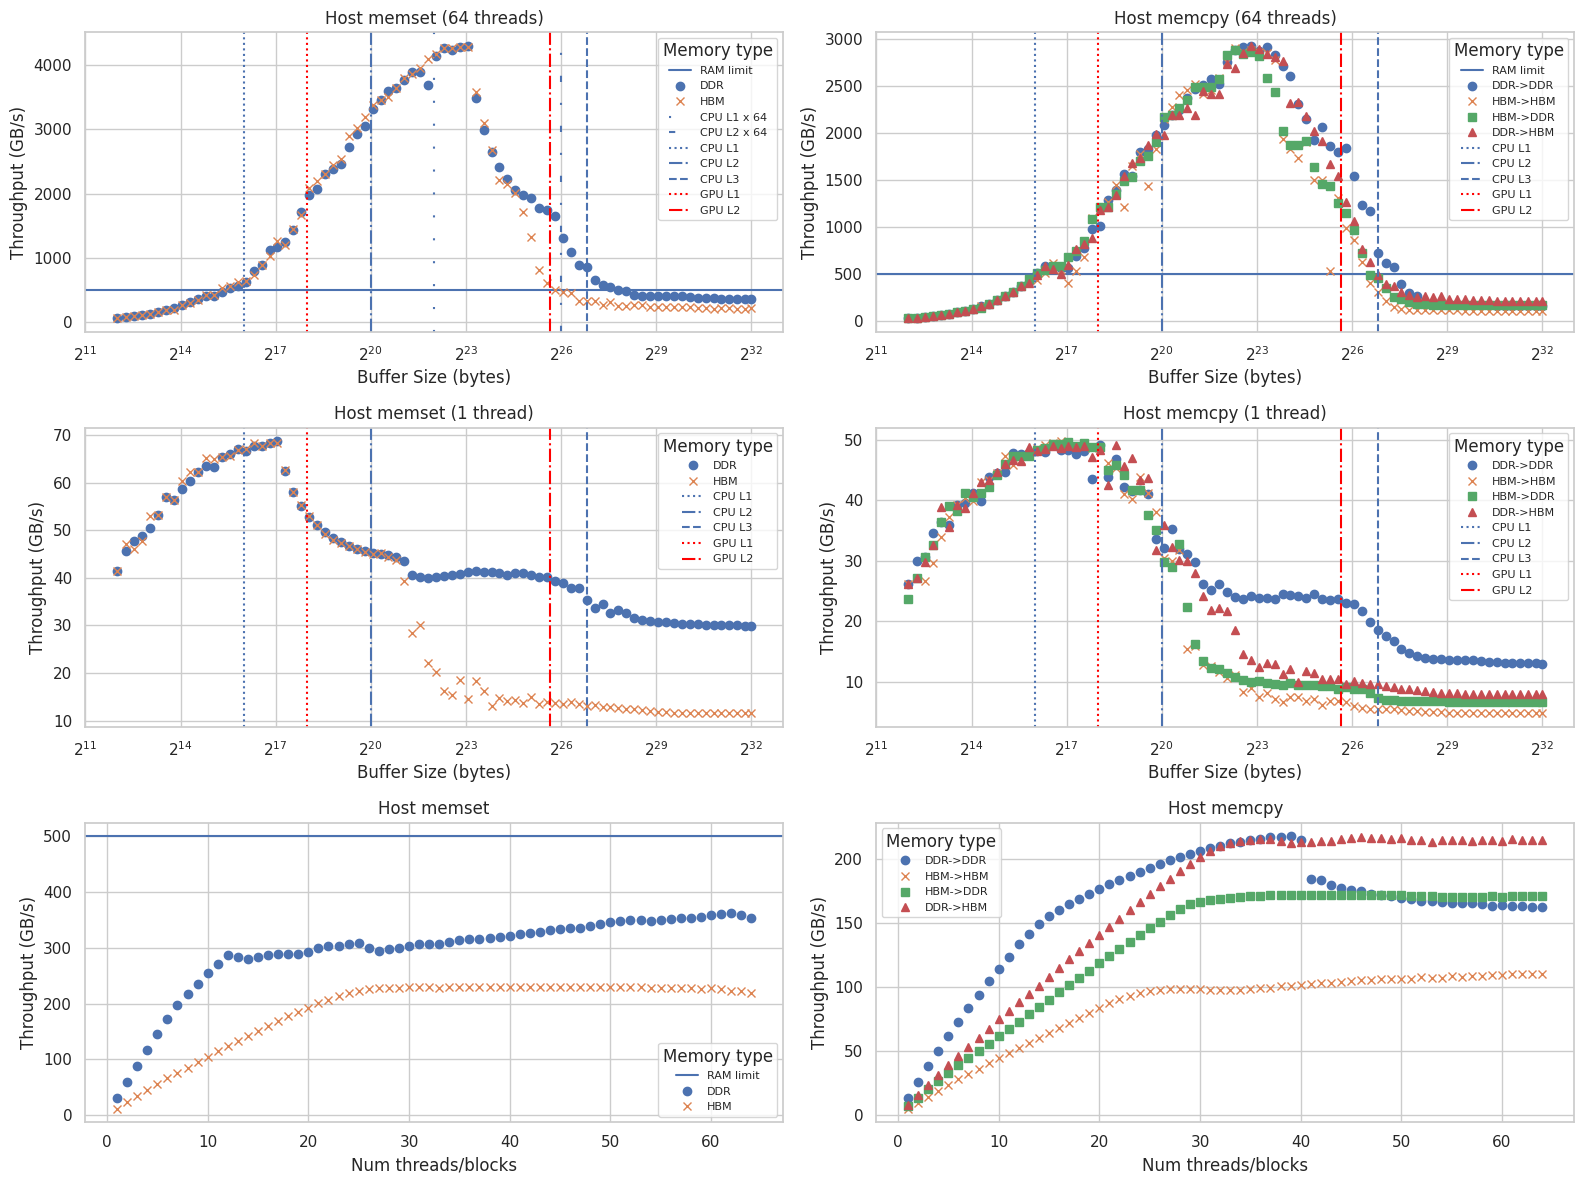

In [23]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,12))
ax1.axhline(y=500, label='RAM limit')
make_read_write_graph(ax1, 'results/memset/host', 'Host memset (64 threads)', False, 64)
ax2.axhline(y=500, label='RAM limit')
make_copy_graph(ax2, 'results/memcpy/host', 'Host memcpy (64 threads)')
make_read_write_graph(ax3, 'results/memset/host/single', 'Host memset (1 thread)')
make_copy_graph(ax4, 'results/memcpy/host/single', 'Host memcpy (1 thread)')
ax5.axhline(y=500, label='RAM limit')
make_read_write_graph(ax5, 'results/memset/host/scalability', 'Host memset', True)
make_copy_graph(ax6, 'results/memcpy/host/scalability', 'Host memcpy', True)
plt.tight_layout()

#getting maxes
host_reads = list(results_generator([str(2**32)], 'results/memset/host/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr memset max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memset/host/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm memset max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memset/host/single/ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr memset max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memset/host/single/hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm memset max {host_reads[0]}')

l = list(str(i) for i in range(1, 65))
host_writes = list(results_generator(l, 'results/memset/host/scalability/ddr', skip=1))
am = np.argmax(host_writes)
print(f'host ddr write max {host_writes[am]} ({am+1} threads)')
host_writes = list(results_generator(l, 'results/memset/host/scalability/hbm', skip=1))
am = np.argmax(host_writes)
print(f'host hbm write max {host_writes[am]} ({am+1} threads)')

host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/ddr_ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr_ddr memcpy max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/hbm_hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm_hbm memcpy max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/hbm_ddr', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host hbm_ddr memcpy max {host_reads[0]}')
host_reads = list(results_generator([str(2**32)], 'results/memcpy/host/single/ddr_hbm', skip=1))
host_reads_argmax = np.argmax(host_reads)
print(f'host ddr_hbm memcpy max {host_reads[0]}')

host_copies = list(results_generator(l, 'results/memcpy/host/scalability/ddr_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/memcpy/host/scalability/hbm_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->hbm copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/memcpy/host/scalability/hbm_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/memcpy/host/scalability/ddr_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->hbm copy max {host_copies[am]} ({am+1} threads)')

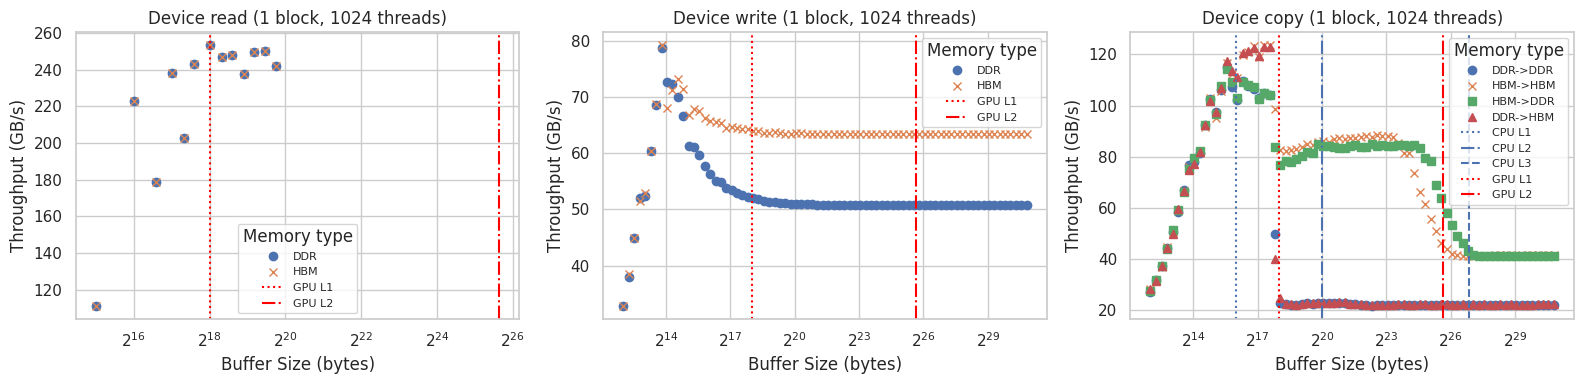

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
make_read_write_graph(ax1, 'results/read/device/block', 'Device read (1 block, 1024 threads)', show_cpu=False)
make_read_write_graph(ax2, 'results/write/device/block', 'Device write (1 block, 1024 threads)', show_cpu=False)
make_copy_graph(ax3, 'results/copy/device/block', 'Device copy (1 block, 1024 threads)')
plt.tight_layout()

host (DDR) 242.30547474747473
host (HBM) 626.4248383838383
device (HBM) 373.97252525252526
device (DDR) 868.4690707070706
host (DDR) 14.777074747474748
host (HBM) 34.269977777777775
device (HBM) 345.41662626262615
device (DDR) 712.2441515151515


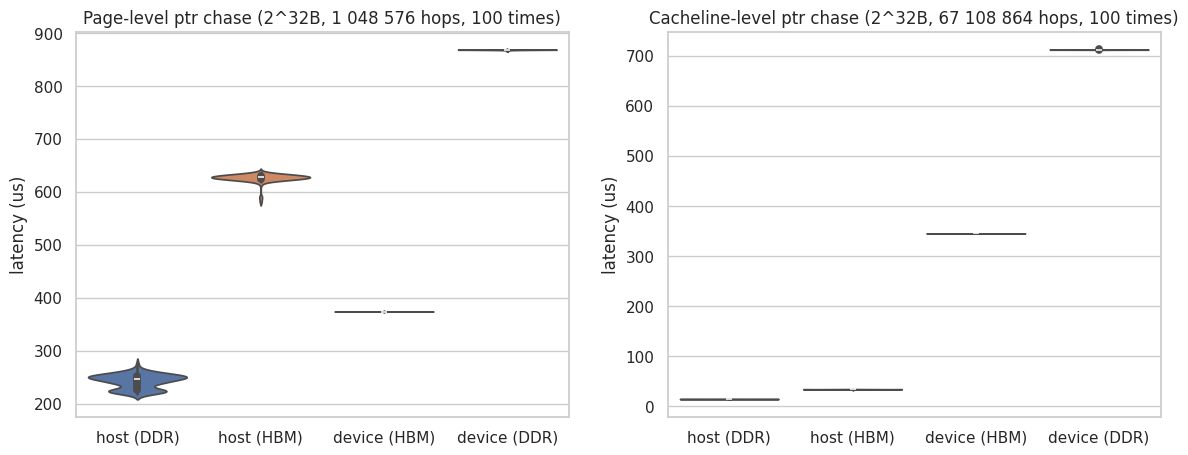

In [56]:
experiments1 = ['host/ddr', 'host/hbm', 'device/hbm', 'device/ddr']
experiments2 = ['fine/host/ddr', 'fine/host/hbm', 'fine/device/hbm', 'fine/device/ddr']
labels = ['host (DDR)', 'host (HBM)', 'device (HBM)', 'device (DDR)']
data1 = {}
data2 = {}

for e, l in zip(experiments1, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data1[l] = elems

for e, l in zip(experiments2, labels):
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data2[l] = elems

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_title('Page-level ptr chase (2^32B, 1 048 576 hops, 100 times)')
ax2.set_title('Cacheline-level ptr chase (2^32B, 67 108 864 hops, 100 times)')
ax1.set_ylabel('latency (us)')
ax2.set_ylabel('latency (us)')
sns.violinplot(data1, ax=ax1)
sns.violinplot(data2, ax=ax2)

# ax3 = fig.add_axes([.58, .5, .2, .3])
# experiments = ['fine/host/ddr', 'fine/host/hbm']
# labels = ['host (DDR)', 'host (HBM)']
# data = {}

# for e, l in zip(experiments, labels):
#     with open('results/latency/' + e, 'r') as file:
#         elems = file.read().split('\n')[1:-1]
#         elems = [float(e) for e in elems]
#         data[l] = elems
# ax = sns.violinplot(data, ax=ax3)

for k, v in data1.items():
    print(k, np.mean(v))
for k, v in data2.items():
    print(k, np.mean(v))

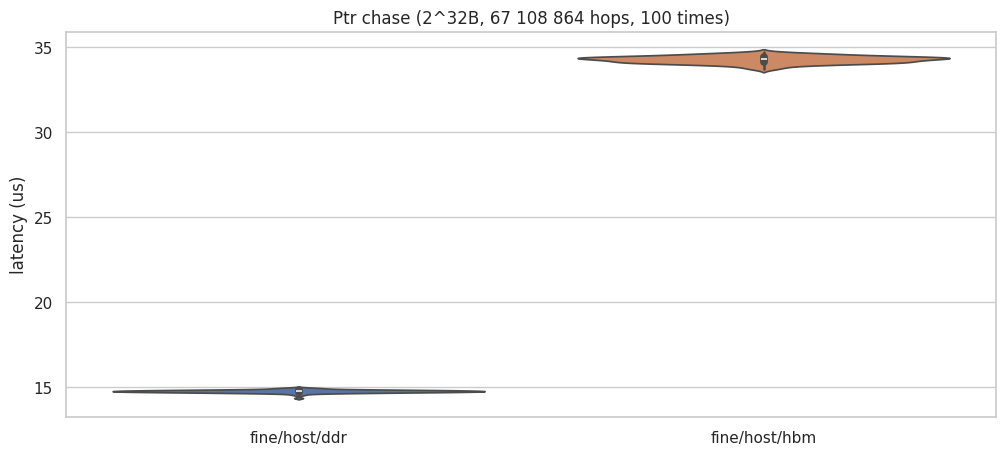

In [53]:
experiments = ['fine/host/ddr', 'fine/host/hbm']
data = {}

for e in experiments:
    with open('results/latency/' + e, 'r') as file:
        elems = file.read().split('\n')[1:-1]
        elems = [float(e) for e in elems]
        data[e] = elems

plt.figure(figsize=(12, 5))
plt.title('Ptr chase (2^32B, 67 108 864 hops, 100 times)')
plt.ylabel('latency (us)')
ax = sns.violinplot(data)

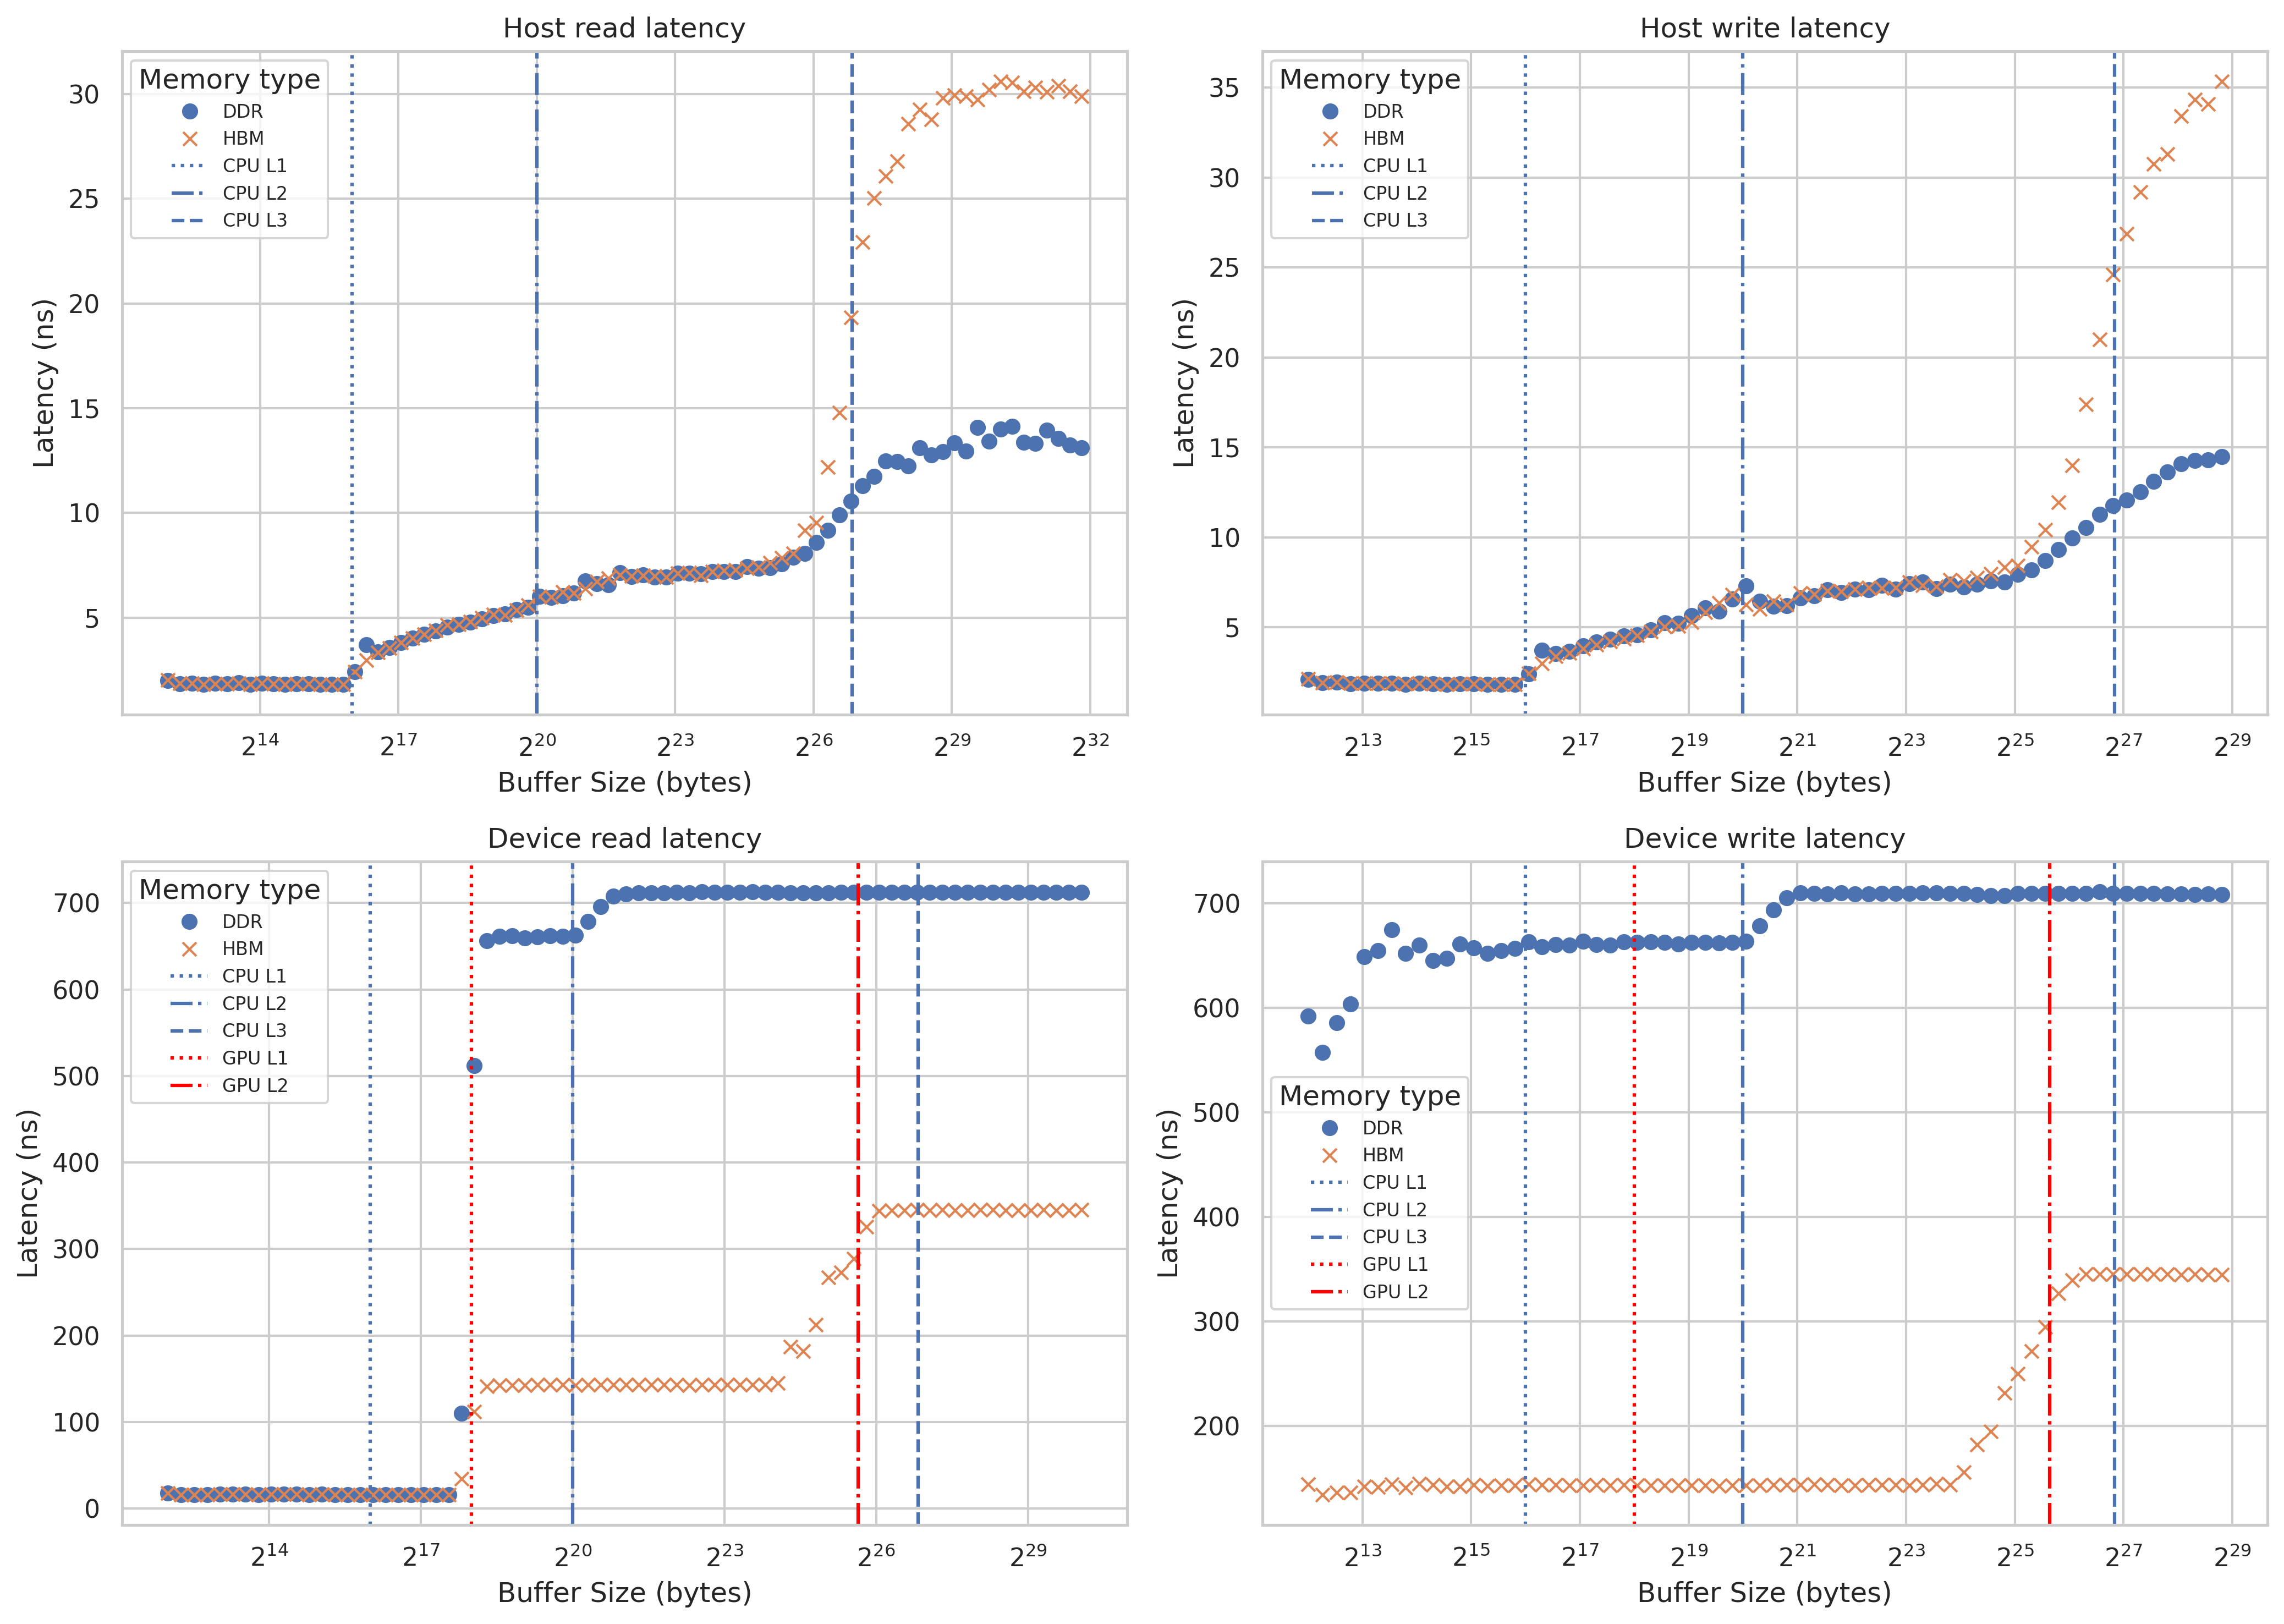

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
fig.set_dpi(300)
make_read_write_graph(ax1, 'results/latency/host/scalability', 'Host read latency', latency=True, skip=10, show_gpu=False)
make_read_write_graph(ax2, 'results/latency/host/scalability/write/', 'Host write latency', latency=True, skip=10, show_gpu=False)
make_read_write_graph(ax3, 'results/latency/device/scalability', 'Device read latency', latency=True, show_cpu=True)
make_read_write_graph(ax4, 'results/latency/device/scalability/write/', 'Device write latency', latency=True, show_cpu=True)
plt.tight_layout()

host ddr read max 430.24577777777785 (41 threads)
host hbm read max 199.38144444444444 (64 threads)
host ddr write max 362.48844444444444 (62 threads)
host hbm write max 230.61344444444447 (40 threads)
host ddr->ddr copy max 227.48422222222223 (60 threads)
host hbm->hbm copy max 104.85066666666665 (63 threads)
host hbm->ddr copy max 180.00022222222222 (64 threads)
host ddr->hbm copy max 216.9811111111111 (47 threads)
device ddr->ddr copy max 216.68122222222223 (36 blocks)
device hbm->hbm copy max 1444.221111111111 (223 blocks)
device hbm->ddr copy max 370.41011111111106 (264 blocks)
device ddr->hbm copy max 409.531 (91 blocks)
device ddr read max 412.18966666666665 (91 threads)
device hbm read max 2655.05 (264 threads)
device ddr write max 374.7646666666667 (128 threads)
device hbm write max 3189.8133333333335 (264 threads)


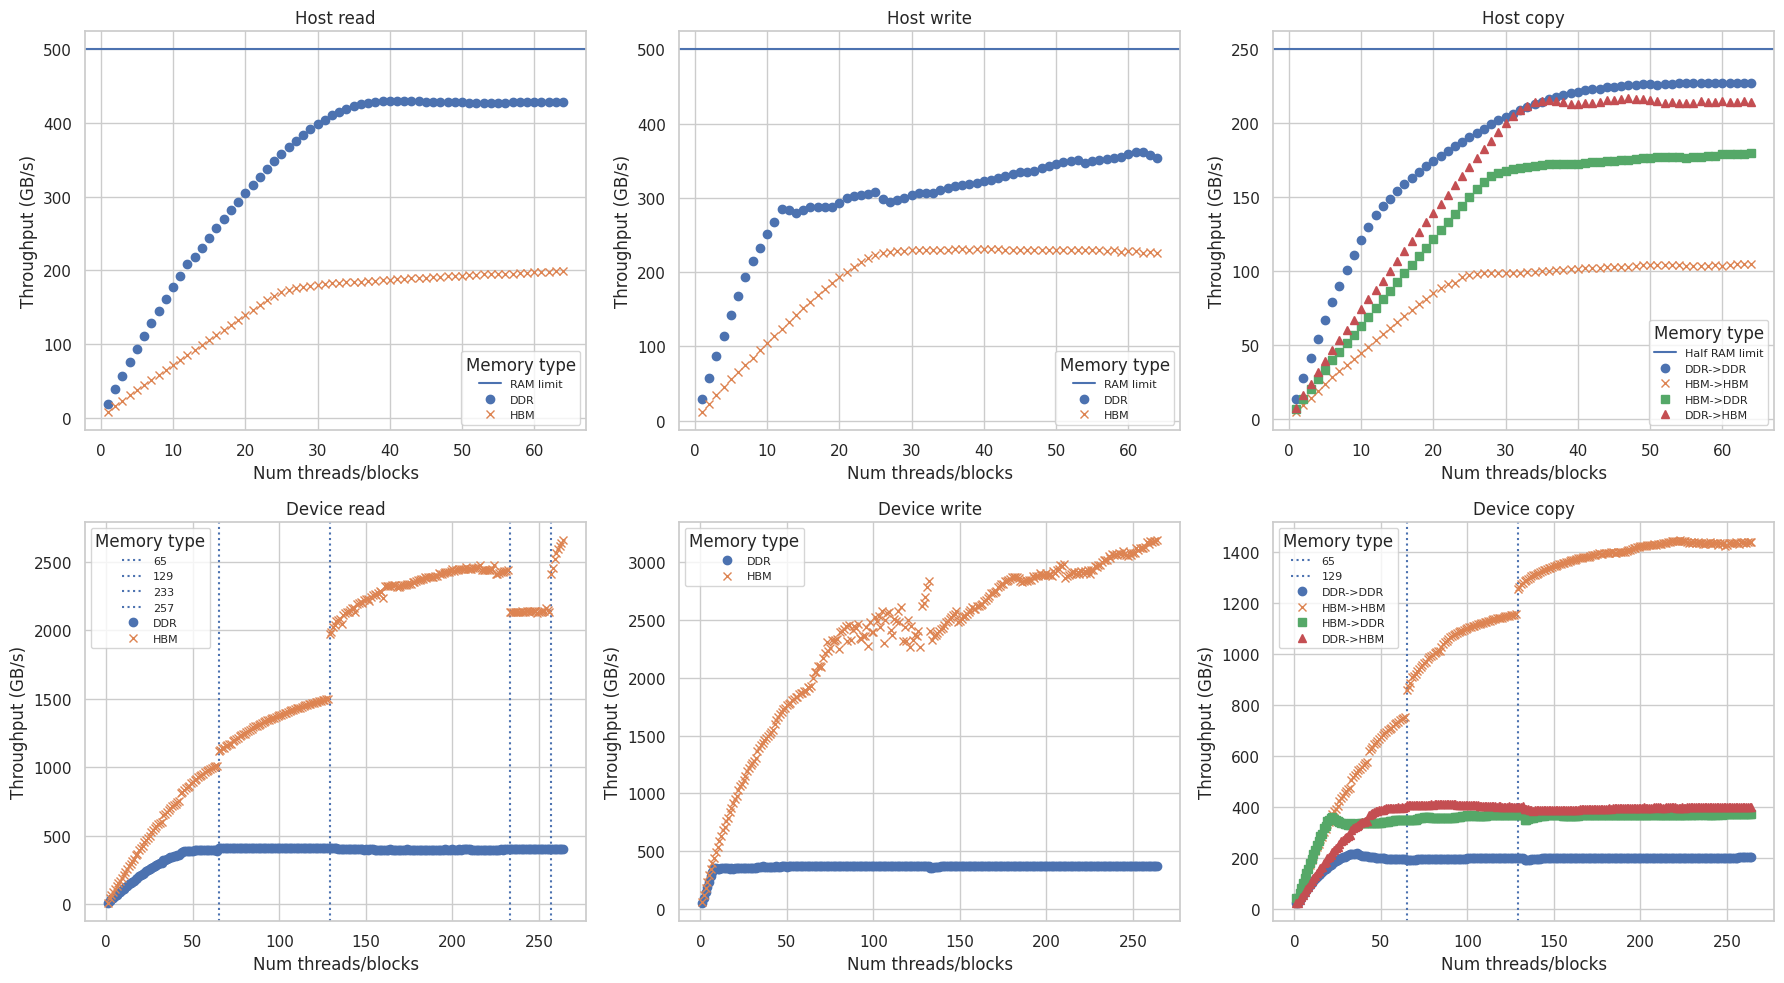

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18,10))
ax4.axvline(x=65, ls=':', label = f'65')
ax4.axvline(x=129, ls=':', label = f'129')
ax4.axvline(x=233, ls=':', label = f'233')
ax4.axvline(x=257, ls=':', label = f'257')
ax6.axvline(x=65, ls=':', label = f'65')
ax6.axvline(x=129, ls=':', label = f'129')
ax1.axhline(y=500, label='RAM limit')
ax2.axhline(y=500, label='RAM limit')
ax3.axhline(y=250, label='Half RAM limit')
make_read_write_graph(ax1, 'results/read/host/scalability', 'Host read', True)
make_read_write_graph(ax2, 'results/write/host/scalability', 'Host write', True)
make_copy_graph(ax3, 'results/copy/host/scalability', 'Host copy', True)
make_read_write_graph(ax4, 'results/read/device/scalability', 'Device read', True)
make_read_write_graph(ax5, 'results/write/device/scalability', 'Device write', True)
make_copy_graph(ax6, 'results/copy/device/scalability', 'Device copy', True)
plt.tight_layout()

#getting maxes
l = list(str(elem) for elem in range(1,65))
host_reads = list(results_generator(l, 'results/read/host/scalability/ddr', skip=1))
am = np.argmax(host_reads)
print(f'host ddr read max {host_reads[am]} ({am+1} threads)')
host_reads = list(results_generator(l, 'results/read/host/scalability/hbm', skip=1))
am = np.argmax(host_reads)
print(f'host hbm read max {host_reads[am]} ({am+1} threads)')
host_writes = list(results_generator(l, 'results/write/host/scalability/ddr', skip=1))
am = np.argmax(host_writes)
print(f'host ddr write max {host_writes[am]} ({am+1} threads)')
host_writes = list(results_generator(l, 'results/write/host/scalability/hbm', skip=1))
am = np.argmax(host_writes)
print(f'host hbm write max {host_writes[am]} ({am+1} threads)')


host_copies = list(results_generator(l, 'results/copy/host/scalability/ddr_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/copy/host/scalability/hbm_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->hbm copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/copy/host/scalability/hbm_ddr', skip=1))
am = np.argmax(host_copies)
print(f'host hbm->ddr copy max {host_copies[am]} ({am+1} threads)')
host_copies = list(results_generator(l, 'results/copy/host/scalability/ddr_hbm', skip=1))
am = np.argmax(host_copies)
print(f'host ddr->hbm copy max {host_copies[am]} ({am+1} threads)')

l = list(str(elem) for elem in range(1,265))
device_copies = list(results_generator(l, 'results/copy/device/scalability/ddr_ddr', skip=1))
am = np.argmax(device_copies)
print(f'device ddr->ddr copy max {device_copies[am]} ({am+1} blocks)')
device_copies = list(results_generator(l, 'results/copy/device/scalability/hbm_hbm', skip=1))
am = np.argmax(device_copies)
print(f'device hbm->hbm copy max {device_copies[am]} ({am+1} blocks)')
device_copies = list(results_generator(l, 'results/copy/device/scalability/hbm_ddr', skip=1))
am = np.argmax(device_copies)
print(f'device hbm->ddr copy max {device_copies[am]} ({am+1} blocks)')
device_copies = list(results_generator(l, 'results/copy/device/scalability/ddr_hbm', skip=1))
am = np.argmax(device_copies)
print(f'device ddr->hbm copy max {device_copies[am]} ({am+1} blocks)')

device_reads = list(results_generator(l, 'results/read/device/scalability/ddr', skip=1))
am = np.argmax(device_reads)
print(f'device ddr read max {device_reads[am]} ({am+1} threads)')
device_reads = list(results_generator(l, 'results/read/device/scalability/hbm', skip=1))
am = np.argmax(device_reads)
print(f'device hbm read max {device_reads[am]} ({am+1} threads)')
device_writes = list(results_generator(l, 'results/write/device/scalability/ddr', skip=1))
am = np.argmax(device_writes)
print(f'device ddr write max {device_writes[am]} ({am+1} threads)')
device_writes = list(results_generator(l, 'results/write/device/scalability/hbm', skip=1))
am = np.argmax(device_writes)
print(f'device hbm write max {device_writes[am]} ({am+1} threads)')


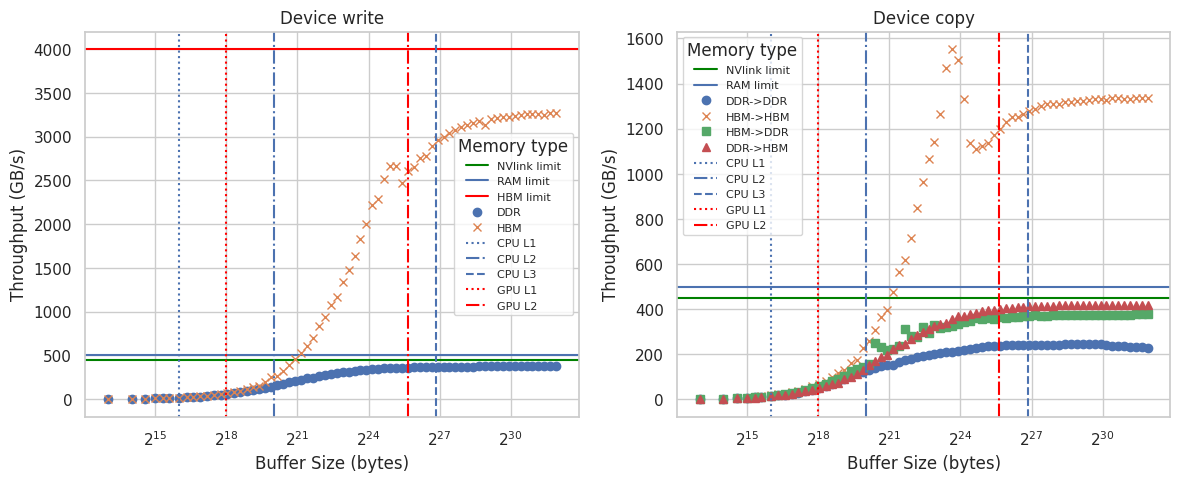

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.axhline(y=450, color='green', label='NVlink limit')
ax1.axhline(y=500, label='RAM limit')
ax1.axhline(y=4000, color='red', label='HBM limit')
ax2.axhline(y=450, color='green', label='NVlink limit')
ax2.axhline(y=500, label='RAM limit')
#ax2.axhline(y=4000, color='red', label='HBM limit')
make_read_write_graph(ax1, 'results/write/device/throughput', 'Device write')
make_copy_graph(ax2, 'results/copy/device/throughput', 'Device copy')

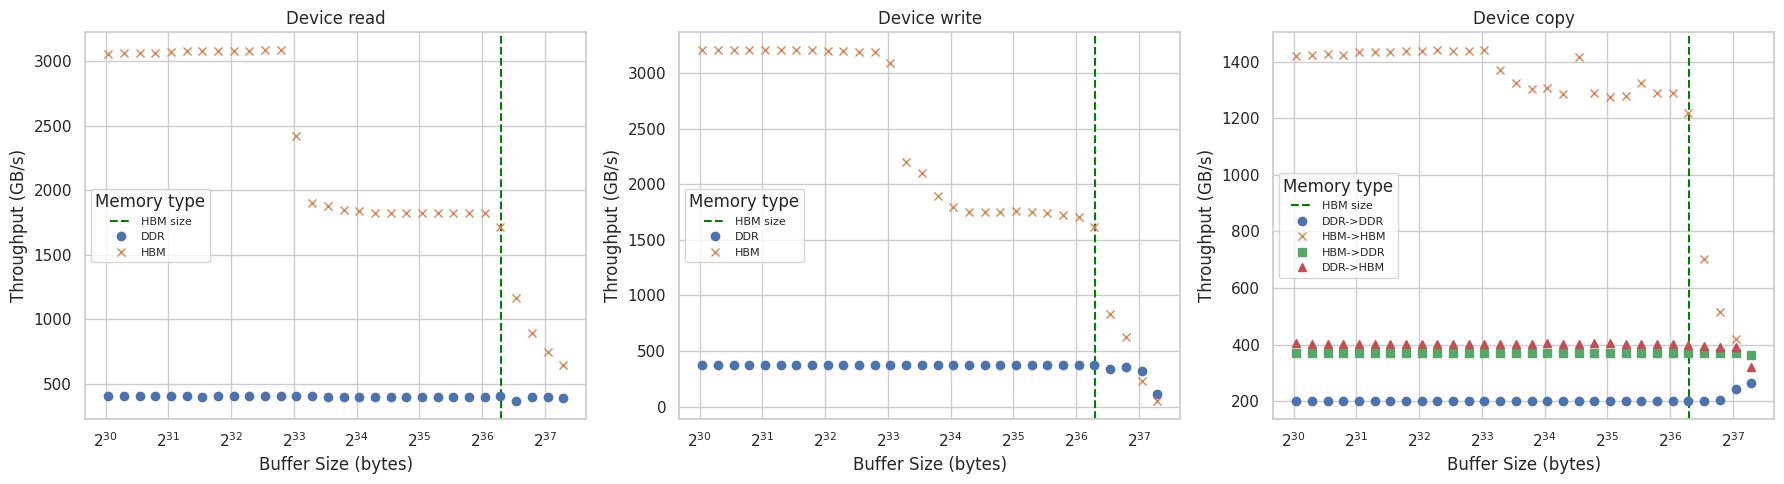

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.axvline(x=84_825_604_096, color='green', ls='--', label='HBM size')
ax2.axvline(x=84_825_604_096, color='green', ls='--', label='HBM size')
ax3.axvline(x=84_825_604_096, color='green', ls='--', label='HBM size')
make_read_write_graph(ax1, 'results/read/device/large', 'Device read', show_caches=False)
make_read_write_graph(ax2, 'results/write/device/large', 'Device write', show_caches=False)
make_copy_graph(ax3, 'results/copy/device/large', 'Device copy', show_caches=False)
plt.tight_layout()

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'device only'),
  Text(0, 1.5, 'managed'),
  Text(0, 2.5, 'host pinned'),
  Text(0, 3.5, 'mmap (Device)'),
  Text(0, 4.5, 'mmap (Host)')])

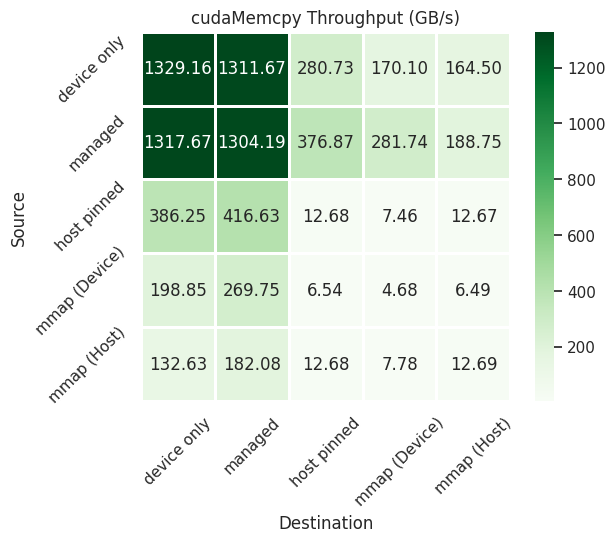

In [25]:
mem_types = ['CMC', 'MGD', 'CMH', 'MMD', 'MMH']
mem_names = ['device only', 'managed', 'host pinned', 'mmap (Device)', 'mmap (Host)']

mem_tuples = zip(mem_types, mem_names)

data = np.zeros((len(mem_types), len(mem_types)));

from itertools import product
for (i, a), (j, b) in product(enumerate(mem_types), enumerate(mem_types)):
    data[i, j] = np.mean(get_raw_results(f'results/memcpy/cuda/heatmap/{a}_{b}'))

plt.figure(dpi=100)
ax = sns.heatmap(data, annot=True, fmt='.2f', xticklabels=mem_names, yticklabels=mem_names, linewidths=1, square=True, cmap='Greens')
ax.set(title="cudaMemcpy Throughput (GB/s)", xlabel="Destination", ylabel="Source")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

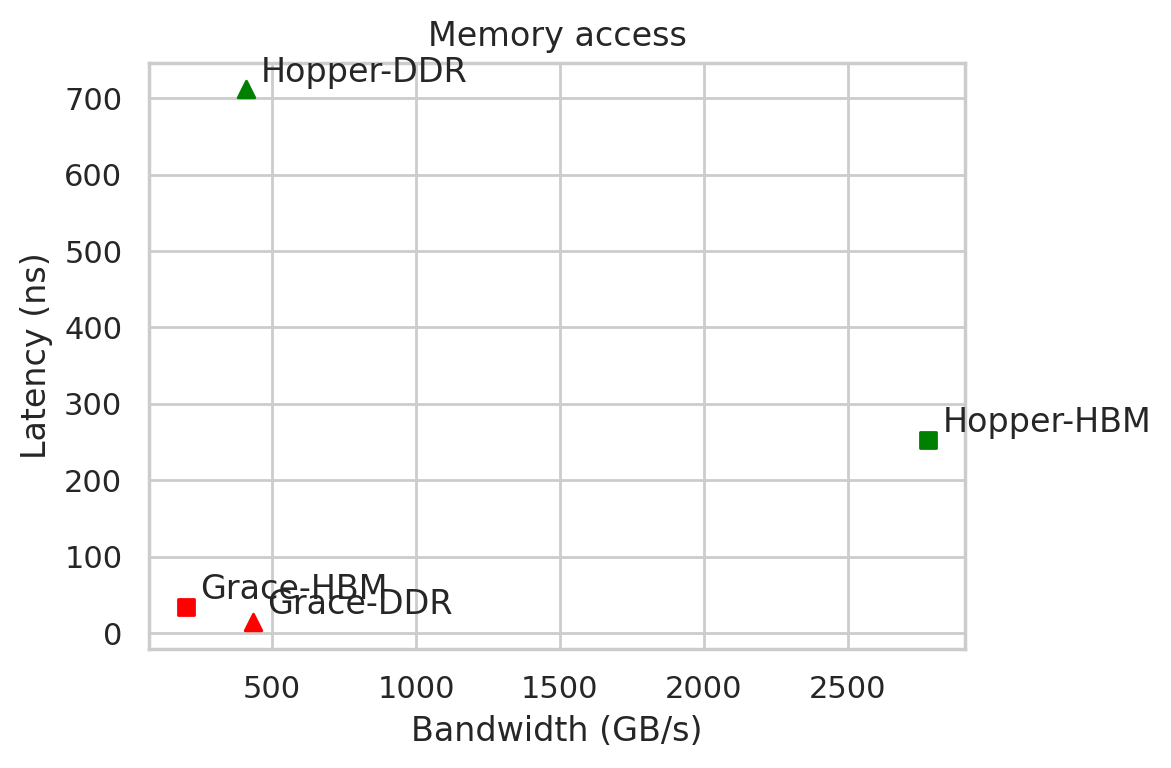

In [13]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.ticker import FuncFormatter, FixedLocator, LogLocator, ScalarFormatter
from math import sqrt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
fig.set_dpi(200)

labels = ['Grace-DDR', 'Grace-HBM', 'Hopper-DDR', 'Hopper-HBM']
x = [431.994, 200.172, 408.774, 2779.127]
y = [14.777, 34.270, 711.711, 252.713]
markers = ['^', 's', '^', 's']
colors = ['red', 'red', 'green', 'green']

for i, c in enumerate(labels):
    xi = [x[j] for j in range(len(x)) if labels[j] == c]
    yi = [y[j] for j in range(len(y)) if labels[j] == c]
    ax.scatter(xi, yi, color=colors[i], marker=markers[i], label=c)
    for label, cur_x, cur_y in zip(labels, xi, yi):
        ax.text(cur_x + 50, cur_y + 10, c)

ax.set(title="Memory access", xlabel="Bandwidth (GB/s)", ylabel="Latency (ns)")

# ax.set_yscale('log', base=10)

# def custom_formatter(val, pos):
#     return f'{val:g}'

# # Use a custom formatter to keep the tick labels linear
# ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
# ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
# ax.xaxis.set_major_locator(LogLocator(base=sqrt(sqrt(10)), numticks=20))
# ax.yaxis.set_major_locator(LogLocator(base=sqrt(sqrt(10)), numticks=20))

plt.tight_layout()

In [ ]:
CPU L1: 65536
CPU L2: 1_048_576
CPU L3: 119_537_664
GPU L1: 262_144
GPU L2: 52_428_800